In [1]:
# --- Imports ---
import pandas as pd

In [2]:
# --- Load data ---
df = pd.read_csv("../data/german_credit_data.csv")
# df = pd.read_csv("../data/german_credit_data.csv", index_col=0)

In [3]:
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [4]:
df.shape

(1000, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.3+ KB


In [6]:
# --- NULL VALUES ---
df.isna().sum()

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

In [7]:
df.set_index('Unnamed: 0', inplace=True)

In [8]:
print(df.columns.tolist())

['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose']


In [9]:
# to avoid chained assignment problems
df = df.copy()

In [10]:
# missing values by filling with a placeholder
df['Saving accounts'] = df['Saving accounts'].fillna('UNAVAILABLE')
df['Checking account'] = df['Checking account'].fillna('UNAVAILABLE')

In [11]:
# Encode categorical attributes

from sklearn.preprocessing import LabelEncoder

# Define categorical columns explicitly
categorical_cols = [
    "Sex",
    "Housing",
    "Saving accounts",
    "Checking account",
    "Purpose"
]

# Dictionary to keep encoders for inverse transform later
encoders = {}

for col in categorical_cols:
    encoder = LabelEncoder()

    # Fit on non-null values only (safer for real data)
    df[col] = encoder.fit_transform(df[col].astype(str))

    encoders[col] = encoder  # store encoder for later use

print("Categorical features encoded successfully.")
df.head()


Categorical features encoded successfully.


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
Unnamed: 0,,,,,,,,,
0,67,1,2,1,0,1,1169,6,5
1,22,0,2,1,1,2,5951,48,5
2,49,1,1,1,1,0,2096,12,3
3,45,1,2,0,1,1,7882,42,4
4,53,1,2,0,1,1,4870,24,1


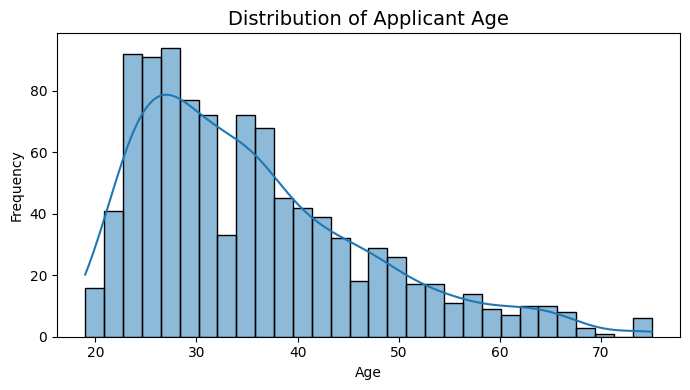

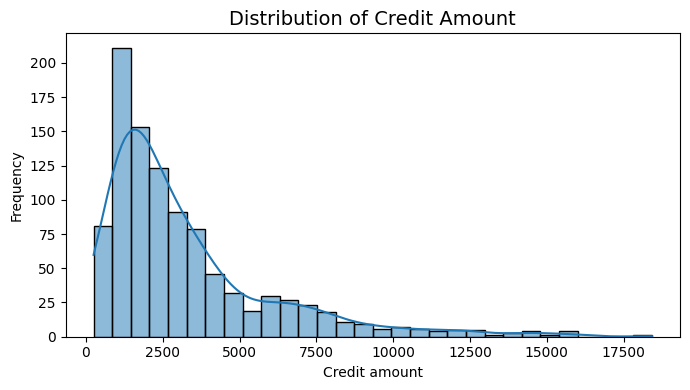

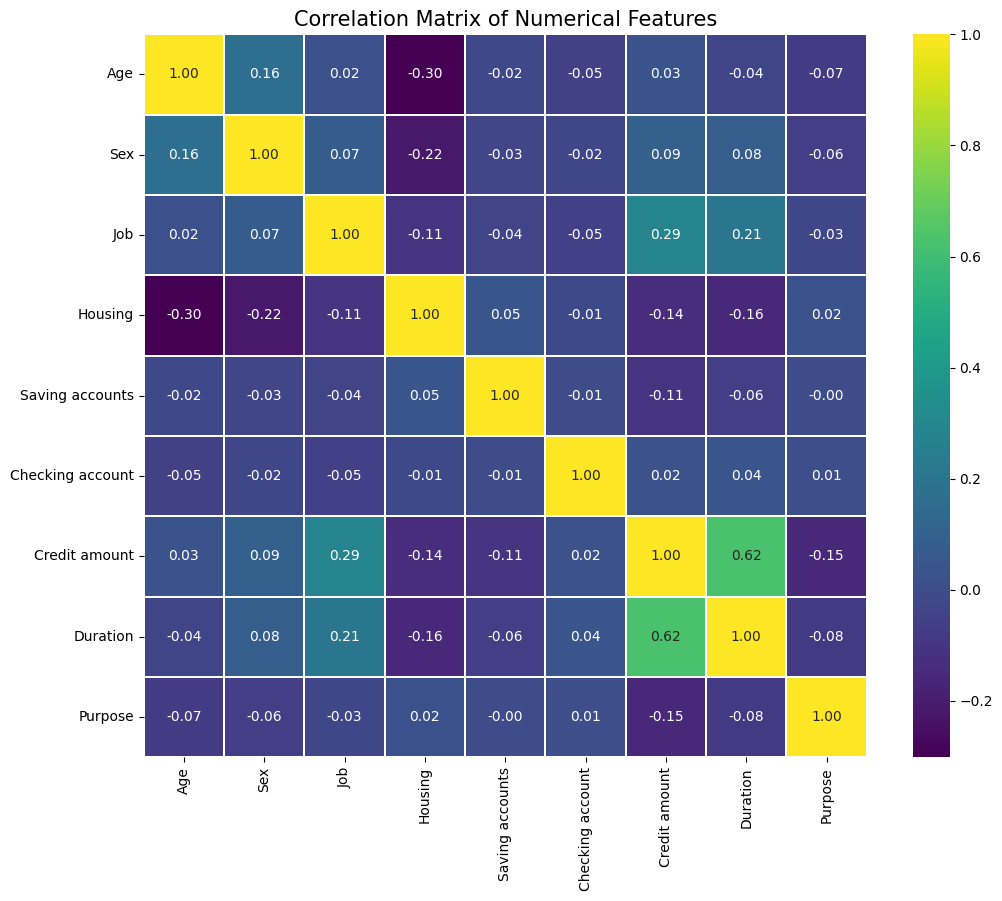

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Clean numeric anomalies and explore key distributions

# Replace infinite values (if any) with NaN for safe statistical processing
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Helper function for clean distribution plots
def plot_distribution(series, title, bins=30):
    plt.figure(figsize=(7, 4))
    sns.histplot(series.dropna(), bins=bins, kde=True)
    plt.title(title, fontsize=14)
    plt.xlabel(series.name)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# 1) Age distribution
plot_distribution(df["Age"], "Distribution of Applicant Age")

# 2) Credit amount distribution
plot_distribution(df["Credit amount"], "Distribution of Credit Amount")

# 3) Correlation heatmap for numerical features
plt.figure(figsize=(11, 9))
corr_matrix = df.corr(numeric_only=True)

sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="viridis",
    linewidths=0.3,
    square=True,
    fmt=".2f"
)

plt.title("Correlation Matrix of Numerical Features", fontsize=15)
plt.tight_layout()
plt.show()


In [13]:
# ===============================================================
# Feature/Target Definition
# ---------------------------------------------------------------
# Here, we define our predictors (X) and create a binary target (y)
# where applicants are labeled as "High Credit Amount" if their
# credit amount is above the dataset's median.
# ===============================================================

X = df.drop(columns=["Credit amount"])
y = (df["Credit amount"] > df["Credit amount"].median()).astype(int)

In [14]:
# ===============================================================
# Train–Test Split
# ---------------------------------------------------------------
# We split the dataset to ensure objective performance evaluation.
# ===============================================================

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3, 
    random_state=42,
    stratify=y
)

In [15]:
# ===============================================================
# Feature Scaling
# ---------------------------------------------------------------
# Standardization ensures that all features contribute proportionally,
# especially beneficial for distance-based or ensemble models.
# ===============================================================

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# ===============================================================
# Model Training (Random Forest)
# ---------------------------------------------------------------
# Random Forest is robust, handles non-linearities well, and provides
# strong baseline performance without heavy tuning.
# ===============================================================

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=120,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

,n_estimators,120
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [17]:
# ===============================================================
# Prediction & Performance Evaluation
# ---------------------------------------------------------------
# We evaluate using accuracy, confusion matrix, and a detailed
# classification report to understand class-level performance.
# ===============================================================

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = rf_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.3f}\n")
print("Confusion Matrix:")
print(conf_mat)
print("\nClassification Report:")
print(report)

Model Accuracy: 0.740

Confusion Matrix:
[[117  33]
 [ 45 105]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       150
           1       0.76      0.70      0.73       150

    accuracy                           0.74       300
   macro avg       0.74      0.74      0.74       300
weighted avg       0.74      0.74      0.74       300



In [18]:
# ===============================================================
# Attach Predictions Back to Test Data
# ---------------------------------------------------------------
# Here, we merge predictions with the original test entries for
# deeper inspection of correctly/incorrectly classified cases.
# ===============================================================

df_test = df.iloc[y_test.index].copy()  # keep original rows
df_test["Predicted"] = y_pred            # model output
df_test["Actual"] = y_test.values        # ground truth

In [19]:
# ===============================================================
# Extract True Positives & True Negatives
# ---------------------------------------------------------------
# Useful to analyze what types of cases the model handles well.
# ===============================================================

true_negatives = df_test[(df_test["Actual"] == 0) & (df_test["Predicted"] == 0)]
true_positives = df_test[(df_test["Actual"] == 1) & (df_test["Predicted"] == 1)]

print("True Negatives (Low Credit Amount predicted correctly):")
display(true_negatives)

print("\nTrue Positives (High Credit Amount predicted correctly):")
display(true_positives)


True Negatives (Low Credit Amount predicted correctly):


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Predicted,Actual
Unnamed: 0,,,,,,,,,,,
254,24,1,2,1,0,2,2030,9,4,0,0
400,39,1,2,1,1,0,1473,18,5,0,0
427,46,1,2,1,4,0,1149,18,5,0,0
27,42,0,2,2,4,3,409,12,5,0,0
2,49,1,1,1,1,0,2096,12,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...
514,54,1,2,1,0,0,2255,24,1,0,0
187,68,1,0,0,1,2,1175,16,1,0,0
22,48,1,1,2,1,1,2241,10,1,0,0



True Positives (High Credit Amount predicted correctly):


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Predicted,Actual
Unnamed: 0,,,,,,,,,,,
141,30,0,3,1,1,2,4795,36,5,1,1
293,56,1,2,0,1,3,4796,42,1,1,1
373,63,1,3,0,0,0,13756,60,1,1,1
352,38,1,3,1,0,0,3229,18,1,1,1
764,27,1,2,1,2,0,2463,24,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
549,35,1,2,0,0,0,8858,48,1,1,1
578,27,1,2,1,1,2,2820,36,1,1,1
671,31,1,2,1,2,0,5742,36,0,1,1
